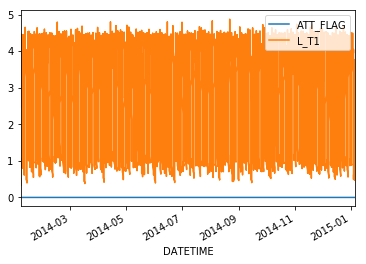

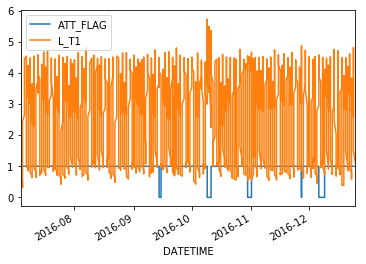

In [178]:
from pandas import read_csv
from pandas import datetime
import pandas
import math
from matplotlib import pyplot
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
import time
from sklearn.decomposition import PCA
import scipy.stats
import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1['ATT_FLAG'] = -df_1['ATT_FLAG']/1000 + 1/1000
df_2['ATT_FLAG'] = -df_2['ATT_FLAG']/1000 + 1/1000
cols = ['ATT_FLAG', 'L_T1']
df_1.plot(x='DATETIME', y= cols)
df_2.plot(x='DATETIME', y= cols)
pyplot.show()

In [108]:
def convert_df(df) :
    labels = df['ATT_FLAG'].values
    x_df = df.drop('ATT_FLAG',1).drop('DATETIME', 1)
    features = x_df.values
    (n,m) = features.shape
    x = scale(features, with_std=False)
    return (x, labels, n,m)
(x_1, y_1, n_1, m_1) = convert_df(df_1)
(x_2, y_2, n_2, m_2) = convert_df(df_2)



array([1., 1., 1., ..., 1., 1., 1.])

PCA Task:

In [186]:
def seperate_anomalous(x_norm,t,m):
    i = 0
    for i in range(0, m):
        u = x_norm[:,i]
        mu = np.mean(u)
        std = np.std(u)
        t_min = mu-(std*t)
        t_max = mu+(std*t)
        breach= np.any(u<t_min) or np.any(u>t_max)
        if breach:
            break
    return i

def calc_SPE(x_a,n):
    spes = np.empty([n])
    for i in range(0,n):
        y = x_a[:,i] 
        spes[i] = np.dot(y, y.T)
    return spes

def calc_q_stat(alpha, x, comps,r,m):
    phi_1 = calc_phi(1,m,r,x,comps)
    phi_2 = calc_phi(2,m,r,x,comps)
    phi_3 = calc_phi(3,m,r,x,comps)
    h_0 = 1 - ((2*phi_1*phi_3)/(3*phi_2**2))
    c_a = scipy.stats.norm.ppf(1-alpha)
    
    left_part = c_a * math.sqrt(2*phi_2* h_0**2)/phi_1
    right_part = phi_2* h_0*(h_0-1) /phi_1**2 
    
    center_part = left_part+1+right_part

    d2_a = phi_1 * center_part**(1/h_0)
    return d2_a
    
def calc_phi(i,m,r,x,comps):  
    res = 0
    for j in range(r+1,m):
        v_j = comps[:,j]
        xv = np.dot(x,v_j)
        l_j = LA.norm(xv)
        res = res + l_j**i
    return res

m = m_2
n = n_2
pca = PCA(n_components=m)
pca.fit(x_2)
proj_x = pca.transform(x_2)
norm_x = normalize(proj_x, norm='l1', axis=0)

#(s_n, s_a) = seperate_anomalous(norm_x, 3)    
idx =  seperate_anomalous(norm_x, 3,m)  
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x_2.T)
x_a = np.dot(I-C, x_2.T)
spes = calc_SPE(x_a,n)
alpha = 0.5
q_stat = calc_q_stat(alpha, x_2, prin_comps,r,m)
safe_traffic = spes <= q_stat


(4177,)

0